# Dummy Test for Precip. Dataset

This notebook is made just for answering my curiosity about two precipitatin dataset in which one of them cannot be applied using EOF function. 

### Open both precipitation dataset 

In [1]:
# import module 


import warnings
import xarray as xr
import pandas as pd
import numpy as np
import dask
import statsmodels as sm
import tensorflow as tf
import collections
import dask
collections.Iterable = collections.abc.Iterable

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from dateutil.parser import parse
from eofs.xarray import Eof
from eofs.examples import example_data_path

In [3]:
# open anomaly precip. dataset from rda 
# the oroginal precip. dataset is not direc precip. but the sum of
# mean large-scale and convective precipitation rate

data_dir = '/data/keeling/a/fsari2/a/ATMS523/data'

pr_rda = xr.open_dataset(data_dir + '/pr_1979-2021_anom.nc')

# see the loaded data

pr_rda

<xarray.Dataset>
Dimensions:                        (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude                       (latitude) float64 65.0 64.75 ... -65.0
  * longitude                      (longitude) float64 120.0 120.2 ... 300.0
  * time                           (time) datetime64[ns] 1979-01-01 ... 2021-...
    month                          (time) int64 ...
Data variables:
    __xarray_dataarray_variable__  (time, latitude, longitude) float32 ...

In [5]:
# open anomaly precip. dataset from era5 
# the original precip. dataset is mean hourly precip.

data_dir = '/data/keeling/a/fsari2/a/ATMS523/data'

pr_era = xr.open_dataset(data_dir + '/prec_1979-2021_anom.nc')

# see the loaded data

pr_era

<xarray.Dataset>
Dimensions:                                  (lat: 521, lon: 721,
                                              valid_time_end_utc: 516)
Coordinates:
  * lat                                      (lat) float32 65.0 64.75 ... -65.0
  * lon                                      (lon) float32 120.0 120.2 ... 300.0
  * valid_time_end_utc                       (valid_time_end_utc) datetime64[ns] ...
    month                                    (valid_time_end_utc) int64 ...
Data variables:
    precipitation_amount_1hour_Accumulation  (valid_time_end_utc, lat, lon) float32 ...

### Plot maps of both precip. dataset

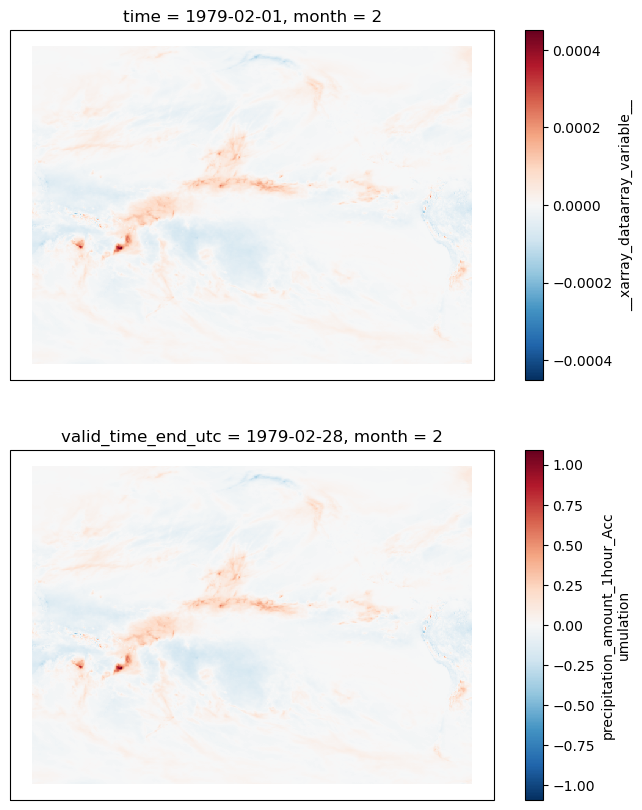

In [15]:
# plot for comparison the original anom. precip. 

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

plt.figure(figsize=(8, 10))

ax1 = plt.subplot(2,1,1, projection=ccrs.PlateCarree(central_longitude=190.0))
check_rda = pr_rda.isel(time=1)
check_rda.__xarray_dataarray_variable__.plot(ax=ax1, transform=ccrs.PlateCarree())

ax2 = plt.subplot(2,1,2, projection=ccrs.PlateCarree(central_longitude=190.0))
check_era = pr_era.isel(valid_time_end_utc=1)
check_era['precipitation_amount_1hour_Accumulation'].plot(ax=ax2,transform=ccrs.PlateCarree())

plt.show()

Both dataset look extremely same, the difference is only on the value range. Thus, we need to see how the dataset look like after some statistical processing. 

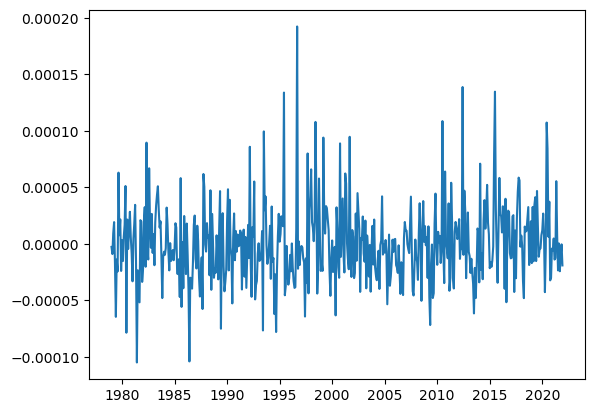

In [22]:
# deseasonal precip. rda dataset and see thow it looks like

mean_pr_rda = pr_rda.groupby('time.month').mean('time')
des_pr_rda = pr_rda.groupby('time.month') - mean_pr_rda

# plot the deseasonalised precip. rda datset

check_des_pr_rda = des_pr_rda.sel(latitude=30, longitude=130, method="nearest")
plt.plot(check_des_pr_rda['time'], check_des_pr_rda['__xarray_dataarray_variable__'])

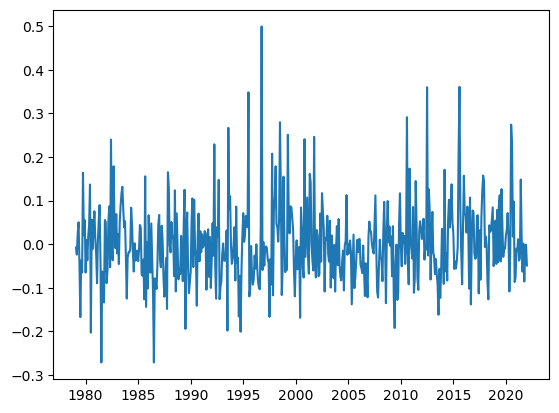

In [24]:
# deseasonal precip. rda dataset and see thow it looks like

mean_pr_era = pr_era.groupby('valid_time_end_utc.month').mean('valid_time_end_utc')
des_pr_era = pr_era.groupby('valid_time_end_utc.month') - mean_pr_era

# plot the deseasonalised precip. era datset

check_des_pr_era = des_pr_era.sel(lat=30, lon=130, method="nearest")
plt.plot(check_des_pr_era['valid_time_end_utc'], check_des_pr_era['precipitation_amount_1hour_Accumulation'])

Both precip. timeseries look really similar, just like the maps. 

In [26]:
# detrend both anomaly precip. dataset

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# get a detrend data for bith anom. precip.

det_pr_rda = detrend_dim(pr_rda['__xarray_dataarray_variable__'],'time',1)
det_pr_era = detrend_dim(pr_era['precipitation_amount_1hour_Accumulation'],'valid_time_end_utc',1)

I did not plot the detrendn as from deasesonalised dataset there is no different. I assume that the timeseries detrended dataset will lokk similar unless the value range. 

In [30]:
# standardize both detrended anom. precip. dataset

mean_pr_rda = det_pr_rda.groupby('time.month').mean('time')
std_pr_rda= det_pr_rda.groupby('time.month').std('time')
stand_pr_rda= xr.apply_ufunc(
                                  lambda x, m, s: (x - m) / s,
                                  det_pr_rda.groupby('time.month'),
                                  mean_pr_rda, std_pr_rda)

mean_pr_era = det_pr_era.groupby('valid_time_end_utc.month').mean('valid_time_end_utc')
std_pr_era = det_pr_era.groupby('valid_time_end_utc.month').std('valid_time_end_utc')
stand_pr_era= xr.apply_ufunc(
                                  lambda x, m, s: (x - m) / s,
                                  det_pr_era.groupby('valid_time_end_utc.month'),
                                  mean_pr_era, std_pr_era)

<Figure size 800x1000 with 0 Axes>

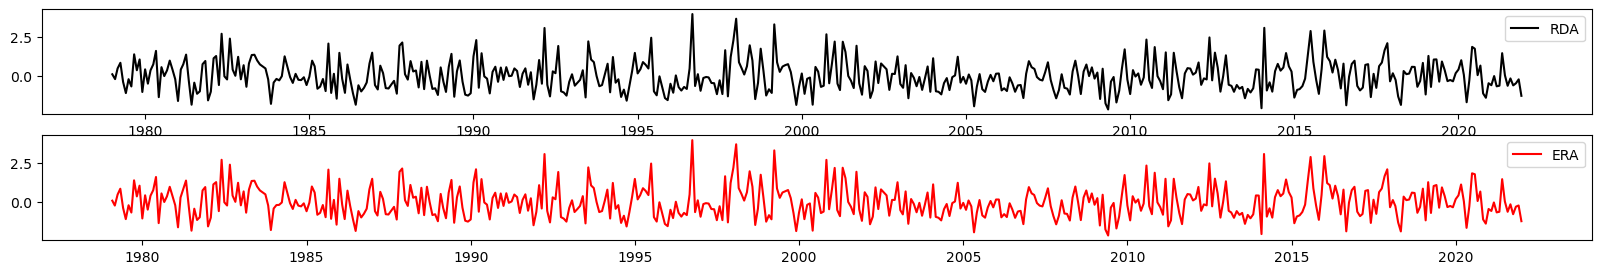

In [34]:
# to check the detrended both anom. precip. dataset 

fig = plt.figure(figsize=(8, 10))

fig,(ax,ax2) = plt.subplots(2,1,sharey=True)
fig.subplots_adjust(wspace=0.05)
fig.set_size_inches(20, 3, forward=True)

check_std_pr_rda = stand_pr_rda.sel(latitude=30, longitude=130, method="nearest")
check_std_pr_era = stand_pr_era.sel(lat=30, lon=130, method="nearest")

ax.plot(check_std_pr_rda['time'], check_std_pr_rda,label='RDA',color='k')
ax2.plot(check_std_pr_era['valid_time_end_utc'], check_std_pr_era,label='ERA',color='red')

ax.legend()
ax2.legend()


After appplying standardization both dataset have both similar trend and value range. 

### Check both anom. precip. dataset

In [37]:
# check standardized anom. precip. rda dataset

stand_pr_rda

<xarray.DataArray (time: 516, latitude: 521, longitude: 721)>
array([[[-1.66605653, -1.58472798, -1.49985658, ...,  2.02094958,
          1.923593  ,  1.81837305],
        [-1.78053349, -1.72047122, -1.66455291, ...,  1.86774668,
          1.85200959,  1.83088068],
        [-1.86596472, -1.78513176, -1.69798632, ...,  1.8013581 ,
          1.78009143,  1.75343692],
        ...,
        [-2.07174044, -2.0354632 , -1.99477721, ..., -1.28647455,
         -1.5805973 , -1.67896654],
        [-1.97386319, -1.92957039, -1.8813837 , ..., -1.45744256,
         -1.48242222, -1.47710711],
        [-1.66157726, -1.6145862 , -1.55940466, ..., -1.50749173,
         -1.48295092, -1.44321379]],

       [[ 0.23256078,  0.24554532,  0.25659923, ...,  3.05991645,
          3.14931971,  3.22220859],
        [ 0.09182434,  0.09504036,  0.08902051, ...,  3.2469547 ,
          3.43803894,  3.63057076],
        [ 0.04186375,  0.0765872 ,  0.0957242 , ...,  3.49353933,
          3.75301138,  3.98050503],
...
        [-0.80721635, -0.82285173, -0.83782285, ...,  1.15301779,
          1.2474063 ,  1.28689432],
        [-0.89442635, -0.90623731, -0.91685491, ...,  0.7229711 ,
          0.68066708,  0.57729162],
        [-0.89658137, -0.90821016, -0.92285084, ...,  0.09338121,
          0.0255921 , -0.09720779]],

       [[-0.74162018, -0.76392441, -0.77512528, ...,  1.86123387,
          1.88616453,  1.90158068],
        [-0.76347756, -0.77020969, -0.7651125 , ...,  1.88504615,
          1.86155889,  1.8332474 ],
        [-0.76398494, -0.82955928, -0.88523239, ...,  1.77834535,
          1.75903553,  1.73244728],
        ...,
        [ 0.88817352,  0.78364728,  0.67276425, ...,  0.82423088,
          0.13690908, -0.61424514],
        [ 0.50152854,  0.36431288,  0.21934301, ..., -0.69541931,
         -0.82258928, -0.94844608],
        [ 0.0329295 , -0.09937864, -0.21946032, ..., -1.08455118,
         -1.05727284, -1.10815603]]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [38]:
# check standardized anom. precip. era dataset

stand_pr_era

<xarray.DataArray (valid_time_end_utc: 516, lat: 521, lon: 721)>
array([[[-1.64809517e+00, -1.56681698e+00, -1.46851738e+00, ...,
          2.02944086e+00,  1.92108611e+00,  1.81680824e+00],
        [-1.79787236e+00, -1.67050152e+00, -1.57825990e+00, ...,
          1.89025922e+00,  1.86424816e+00,  1.84684908e+00],
        [-1.79655501e+00, -1.72852253e+00, -1.62709775e+00, ...,
          1.80120396e+00,  1.78476782e+00,  1.78447786e+00],
        ...,
        [-2.03554354e+00, -2.01360178e+00, -2.00791235e+00, ...,
         -1.28970305e+00, -1.60142150e+00, -1.65362126e+00],
        [-2.01367968e+00, -1.97248102e+00, -1.89102560e+00, ...,
         -1.46910646e+00, -1.49784440e+00, -1.47332840e+00],
        [-1.70294391e+00, -1.68691218e+00, -1.58894552e+00, ...,
         -1.48431334e+00, -1.45141161e+00, -1.42352150e+00]],

       [[ 1.93266481e-01,  2.24324191e-01,  2.67102645e-01, ...,
          2.95281640e+00,  3.06359559e+00,  3.18272013e+00],
        [ 8.77479730e-02,  6.14548469e-02, -1.24363342e-02, ...,
          3.14091308e+00,  3.38443080e+00,  3.63883898e+00],
        [ 1.00876958e-01,  8.99902435e-02,  4.02578342e-02, ...,
          3.44929432e+00,  3.71983013e+00,  3.95249767e+00],
...
        [-8.48245981e-01, -8.57356876e-01, -8.81107214e-01, ...,
          1.13077318e+00,  1.23787603e+00,  1.25712230e+00],
        [-9.16103279e-01, -9.41882779e-01, -9.67233818e-01, ...,
          6.88141804e-01,  6.78640363e-01,  5.77912574e-01],
        [-9.25459253e-01, -9.43071412e-01, -9.59218711e-01, ...,
          8.05826219e-02,  9.91205819e-04, -9.69949970e-02]],

       [[-7.99530038e-01, -8.07898498e-01, -8.28595822e-01, ...,
          1.78767322e+00,  1.82752526e+00,  1.84034831e+00],
        [-7.74561271e-01, -7.97443856e-01, -7.73637319e-01, ...,
          1.84736340e+00,  1.82499050e+00,  1.77199304e+00],
        [-8.02220516e-01, -8.17559491e-01, -9.32017167e-01, ...,
          1.73916157e+00,  1.70113777e+00,  1.66226907e+00],
        ...,
        [ 8.87164453e-01,  8.02817828e-01,  7.15300123e-01, ...,
          7.82158861e-01,  1.09199447e-01, -6.14508170e-01],
        [ 5.64573256e-01,  4.49995512e-01,  3.10459356e-01, ...,
         -6.69356465e-01, -8.16722371e-01, -9.07615835e-01],
        [ 6.72458073e-02, -4.44424022e-02, -2.23902313e-01, ...,
         -1.09157979e+00, -1.06087283e+00, -1.07454459e+00]]])
Coordinates:
  * lat                 (lat) float32 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * lon                 (lon) float32 120.0 120.2 120.5 ... 299.5 299.8 300.0
  * valid_time_end_utc  (valid_time_end_utc) datetime64[ns] 1979-01-31 ... 20...
    month               (valid_time_end_utc) int64 1 2 3 4 5 6 ... 8 9 10 11 12

### Drop the unwanted `month` coordinate and manipulate the era dataset

In [41]:
# drop both month coordinate 

ds_pr_era = stand_pr_era.drop_vars('month')
ds_pr_rda = stand_pr_rda.drop_vars('month')


In [ ]:
# manipulate the era dataset so it will have 
# same dimension name as rda dataset

ds_pr_era = ds_pr_era.rename(
    {'valid_time_end_utc': 'time',\
        'lat': 'latitude',\
            'lon': 'longitude'
    })

In [45]:
# check the loaded both anom. precip. dataset

ds_pr_era

<xarray.DataArray (time: 516, latitude: 521, longitude: 721)>
array([[[-1.64809517e+00, -1.56681698e+00, -1.46851738e+00, ...,
          2.02944086e+00,  1.92108611e+00,  1.81680824e+00],
        [-1.79787236e+00, -1.67050152e+00, -1.57825990e+00, ...,
          1.89025922e+00,  1.86424816e+00,  1.84684908e+00],
        [-1.79655501e+00, -1.72852253e+00, -1.62709775e+00, ...,
          1.80120396e+00,  1.78476782e+00,  1.78447786e+00],
        ...,
        [-2.03554354e+00, -2.01360178e+00, -2.00791235e+00, ...,
         -1.28970305e+00, -1.60142150e+00, -1.65362126e+00],
        [-2.01367968e+00, -1.97248102e+00, -1.89102560e+00, ...,
         -1.46910646e+00, -1.49784440e+00, -1.47332840e+00],
        [-1.70294391e+00, -1.68691218e+00, -1.58894552e+00, ...,
         -1.48431334e+00, -1.45141161e+00, -1.42352150e+00]],

       [[ 1.93266481e-01,  2.24324191e-01,  2.67102645e-01, ...,
          2.95281640e+00,  3.06359559e+00,  3.18272013e+00],
        [ 8.77479730e-02,  6.14548469e-02, -1.24363342e-02, ...,
          3.14091308e+00,  3.38443080e+00,  3.63883898e+00],
        [ 1.00876958e-01,  8.99902435e-02,  4.02578342e-02, ...,
          3.44929432e+00,  3.71983013e+00,  3.95249767e+00],
...
        [-8.48245981e-01, -8.57356876e-01, -8.81107214e-01, ...,
          1.13077318e+00,  1.23787603e+00,  1.25712230e+00],
        [-9.16103279e-01, -9.41882779e-01, -9.67233818e-01, ...,
          6.88141804e-01,  6.78640363e-01,  5.77912574e-01],
        [-9.25459253e-01, -9.43071412e-01, -9.59218711e-01, ...,
          8.05826219e-02,  9.91205819e-04, -9.69949970e-02]],

       [[-7.99530038e-01, -8.07898498e-01, -8.28595822e-01, ...,
          1.78767322e+00,  1.82752526e+00,  1.84034831e+00],
        [-7.74561271e-01, -7.97443856e-01, -7.73637319e-01, ...,
          1.84736340e+00,  1.82499050e+00,  1.77199304e+00],
        [-8.02220516e-01, -8.17559491e-01, -9.32017167e-01, ...,
          1.73916157e+00,  1.70113777e+00,  1.66226907e+00],
        ...,
        [ 8.87164453e-01,  8.02817828e-01,  7.15300123e-01, ...,
          7.82158861e-01,  1.09199447e-01, -6.14508170e-01],
        [ 5.64573256e-01,  4.49995512e-01,  3.10459356e-01, ...,
         -6.69356465e-01, -8.16722371e-01, -9.07615835e-01],
        [ 6.72458073e-02, -4.44424022e-02, -2.23902313e-01, ...,
         -1.09157979e+00, -1.06087283e+00, -1.07454459e+00]]])
Coordinates:
  * latitude   (latitude) float32 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float32 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2021-12-31

In [46]:
ds_pr_rda

<xarray.DataArray (time: 516, latitude: 521, longitude: 721)>
array([[[-1.66605653, -1.58472798, -1.49985658, ...,  2.02094958,
          1.923593  ,  1.81837305],
        [-1.78053349, -1.72047122, -1.66455291, ...,  1.86774668,
          1.85200959,  1.83088068],
        [-1.86596472, -1.78513176, -1.69798632, ...,  1.8013581 ,
          1.78009143,  1.75343692],
        ...,
        [-2.07174044, -2.0354632 , -1.99477721, ..., -1.28647455,
         -1.5805973 , -1.67896654],
        [-1.97386319, -1.92957039, -1.8813837 , ..., -1.45744256,
         -1.48242222, -1.47710711],
        [-1.66157726, -1.6145862 , -1.55940466, ..., -1.50749173,
         -1.48295092, -1.44321379]],

       [[ 0.23256078,  0.24554532,  0.25659923, ...,  3.05991645,
          3.14931971,  3.22220859],
        [ 0.09182434,  0.09504036,  0.08902051, ...,  3.2469547 ,
          3.43803894,  3.63057076],
        [ 0.04186375,  0.0765872 ,  0.0957242 , ...,  3.49353933,
          3.75301138,  3.98050503],
...
        [-0.80721635, -0.82285173, -0.83782285, ...,  1.15301779,
          1.2474063 ,  1.28689432],
        [-0.89442635, -0.90623731, -0.91685491, ...,  0.7229711 ,
          0.68066708,  0.57729162],
        [-0.89658137, -0.90821016, -0.92285084, ...,  0.09338121,
          0.0255921 , -0.09720779]],

       [[-0.74162018, -0.76392441, -0.77512528, ...,  1.86123387,
          1.88616453,  1.90158068],
        [-0.76347756, -0.77020969, -0.7651125 , ...,  1.88504615,
          1.86155889,  1.8332474 ],
        [-0.76398494, -0.82955928, -0.88523239, ...,  1.77834535,
          1.75903553,  1.73244728],
        ...,
        [ 0.88817352,  0.78364728,  0.67276425, ...,  0.82423088,
          0.13690908, -0.61424514],
        [ 0.50152854,  0.36431288,  0.21934301, ..., -0.69541931,
         -0.82258928, -0.94844608],
        [ 0.0329295 , -0.09937864, -0.21946032, ..., -1.08455118,
         -1.05727284, -1.10815603]]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

### Load the sst anomaly dataset and apply for EOF 

In [49]:
# open the saved SST anomalies dataset and 
# the anomalies was already in the deg-C as they are a product of substraction

data_dir = '/data/keeling/a/fsari2/a/ATMS523/data'
sst = xr.open_dataset(data_dir + '/sst_1979-2021_anom.nc')

# deseasonalize monthly means SST anomalies
month_mean_anom_sst = sst.groupby('time.month').mean('time')
des_anom_sst = sst.groupby('time.month') - month_mean_anom_sst

# get a detrend data
det_anom_sst = detrend_dim(des_anom_sst['SSTK'],'time',1)

# standardize the anomalies data
# here we use dataset after applying detrend process

month_mean_anom_sst = det_anom_sst.groupby('time.month').mean('time')
month_std_anom_sst = det_anom_sst.groupby('time.month').std('time')
stand_anom_sst = xr.apply_ufunc(
                                  lambda x, m, s: (x - m) / s,
                                  det_anom_sst.groupby('time.month'),
                                  month_mean_anom_sst, month_std_anom_sst)

# drop the month coordinate 

ds_sst = stand_anom_sst.drop_vars('month')

# to check the result whether it has same dimensions

ds_sst


<xarray.DataArray (time: 516, latitude: 521, longitude: 721)>
array([[[        nan,         nan,         nan, ...,  1.65651349,
          1.59786055,  1.52052848],
        [        nan,         nan,         nan, ...,  1.57343177,
          1.44655235,  1.29924576],
        [        nan,         nan,         nan, ...,  1.49853074,
          1.33857914,  1.16698839],
        ...,
        [-0.59993872, -0.59324391, -0.58261938, ...,         nan,
                 nan,         nan],
        [-1.81840949, -1.79183806, -1.75346826, ...,         nan,
                 nan,         nan],
        [-1.51883701, -1.50324642, -1.49214351, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  1.68783284,
          1.68668333,  1.6855551 ],
        [        nan,         nan,         nan, ...,  1.68513014,
          1.67429679,  1.65933292],
        [        nan,         nan,         nan, ...,  1.67789372,
          1.65518294,  1.62670733],
...
        [-1.32749451, -1.3730135 , -1.40042806, ...,         nan,
                 nan,         nan],
        [-1.50010484, -1.49299325, -1.48517993, ...,         nan,
                 nan,         nan],
        [-1.66725387, -1.66194288, -1.66345106, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -1.22099463,
         -1.27741234, -1.28437199],
        [        nan,         nan,         nan, ..., -1.08803336,
         -1.04955919, -0.98699033],
        [        nan,         nan,         nan, ..., -1.01267136,
         -0.92204319, -0.83119406],
        ...,
        [-0.47062257, -0.41795435, -0.36428273, ...,         nan,
                 nan,         nan],
        [-1.14766381, -1.11199766, -1.06910356, ...,         nan,
                 nan,         nan],
        [-1.34758882, -1.32466763, -1.33127447, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

In [50]:
# apply EOF analysis to dataset

coslat = np.cos(np.deg2rad(ds_sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(ds_sst, weights=wgts)

In [51]:
# calculate the reconstructed SST only for the first EOFs

rec_sst_eof1 = solver.reconstructedField(1)

# check the result

rec_sst_eof1

<xarray.DataArray (time: 516, latitude: 521, longitude: 721)>
array([[[        nan,         nan,         nan, ..., -0.00953647,
         -0.01032906, -0.01091018],
        [        nan,         nan,         nan, ..., -0.01042687,
         -0.01141008, -0.01225591],
        [        nan,         nan,         nan, ..., -0.01130961,
         -0.01253074, -0.01344159],
        ...,
        [ 0.01154566,  0.01104532,  0.01043287, ...,         nan,
                 nan,         nan],
        [ 0.01178703,  0.01162704,  0.01138952, ...,         nan,
                 nan,         nan],
        [ 0.0071848 ,  0.00709771,  0.00677543, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.02009598,
          0.02176618,  0.02299075],
        [        nan,         nan,         nan, ...,  0.0219723 ,
          0.02404419,  0.02582659],
        [        nan,         nan,         nan, ...,  0.02383247,
          0.02640572,  0.02832513],
...
        [-0.16069774, -0.15373377, -0.14520939, ...,         nan,
                 nan,         nan],
        [-0.16405722, -0.16183044, -0.1585245 , ...,         nan,
                 nan,         nan],
        [-0.10000127, -0.09878911, -0.09430349, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.11710592,
          0.12683873,  0.13397474],
        [        nan,         nan,         nan, ...,  0.12803986,
          0.14011349,  0.15050009],
        [        nan,         nan,         nan, ...,  0.13887969,
          0.15387488,  0.16505991],
        ...,
        [-0.14177831, -0.13563423, -0.12811345, ...,         nan,
                 nan,         nan],
        [-0.14474227, -0.14277765, -0.13986094, ...,         nan,
                 nan,         nan],
        [-0.08822782, -0.08715838, -0.08320086, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
Attributes:
    long_name:  None_reconstructed_with_1_EOFs

### Calculate the Pearson correlation for both dataset

In [52]:
# calculate correlation for rda dataset

corr_sst_pr_rda = xr.corr(rec_sst_eof1, ds_pr_rda, dim="time")

# check the correlation 

corr_sst_pr_rda

<xarray.DataArray (latitude: 521, longitude: 721)>
array([[       nan,        nan,        nan, ..., 0.0626572 , 0.06353908,
        0.06402742],
       [       nan,        nan,        nan, ..., 0.06497492, 0.06869011,
        0.07197865],
       [       nan,        nan,        nan, ..., 0.07106061, 0.07450241,
        0.07764224],
       ...,
       [0.02118344, 0.02600025, 0.03077426, ...,        nan,        nan,
               nan],
       [0.02542006, 0.03041998, 0.03521606, ...,        nan,        nan,
               nan],
       [0.03230849, 0.03569857, 0.03742008, ...,        nan,        nan,
               nan]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0

In [55]:
# calculate correlation for rda dataset

corr_sst_pr_era = xr.corr(rec_sst_eof1, ds_pr_era, dim="time")

# check the correlation 

corr_sst_pr_era

<xarray.DataArray (latitude: 521, longitude: 721)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0

Here we can see both precip. dataset already manipulated so that they have similar data array structure. However when they are correlated, they result different value. This makes ERA dataset cannot be plotted. Why is it can be like that? What makes `xr.corr` cannot be applied for ERA dataset?